In [0]:
import os
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

%load_ext tensorboard
import matplotlib.pyplot as plt
from skimage import color, exposure

from sklearn.metrics import accuracy_score

In [38]:
cd "/content/drive/My Drive/Colab Notebooks/dw_matrix/data/"

/content/drive/My Drive/Colab Notebooks/dw_matrix/data


In [0]:
train = pd.read_pickle("train.p")
test = pd.read_pickle("test.p")

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [40]:
y_train

array([41, 41, 41, ..., 25, 25, 25], dtype=uint8)

In [41]:
len(np.unique(y_train))

43

In [42]:
to_categorical(y_train)[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [0]:
if y_train.ndim == 1: y_train = to_categorical(y_train)
if y_test.ndim == 1: y_test = to_categorical(y_test)

In [0]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

In [45]:
model = Sequential([
  Conv2D(filters=64, kernel_size=(3,3), activation="relu", input_shape = input_shape),

  Flatten(),

  Dense(num_classes, activation="softmax")
])
#model.summary()

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="Adam")
model.fit(X_train, y_train)

1088/1088 [==============================] - 4s 4ms/step - loss: 8.3908 - accuracy: 0.7953


In [0]:
def get_cnn_v1(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=64, kernel_size=(3,3), activation="relu", input_shape = input_shape),

    Flatten(),

    Dense(num_classes, activation="softmax")
])
  
def train_model(model, X_train, y_train, params_fit={}):
  model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="Adam")

  logdir=os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  model.fit(
      X_train,
      y_train,
      batch_size=params_fit.get("batch_size", 128),
      epochs=params_fit.get("epochs", 5),
      verbose=params_fit.get("verbose", 1),
      validation_data=params_fit.get("validation_data", (X_train, y_train)),
      callbacks=[tensorboard_callback]
      )
  
  return model

In [47]:
model = get_cnn_v1(input_shape, num_classes)
model_trained = train_model(model, X_train, y_train)

Epoch 1/5
272/272 [==============================] - 3s 11ms/step - loss: 24.2976 - accuracy: 0.7444 - val_loss: 0.2418 - val_accuracy: 0.9433
Epoch 2/5
272/272 [==============================] - 3s 11ms/step - loss: 0.2014 - accuracy: 0.9528 - val_loss: 0.1128 - val_accuracy: 0.9742
Epoch 3/5
272/272 [==============================] - 3s 11ms/step - loss: 0.1252 - accuracy: 0.9717 - val_loss: 0.0801 - val_accuracy: 0.9822
Epoch 4/5
272/272 [==============================] - 3s 11ms/step - loss: 0.0965 - accuracy: 0.9773 - val_loss: 0.0693 - val_accuracy: 0.9844
Epoch 5/5
272/272 [==============================] - 3s 11ms/step - loss: 0.1108 - accuracy: 0.9763 - val_loss: 0.1232 - val_accuracy: 0.9742


In [0]:
######

In [49]:
y_pred_prob = model_trained.predict(X_test)
y_pred_prob[400]

array([9.94884789e-01, 5.07816719e-03, 3.55035354e-06, 1.74188153e-05,
       1.58296098e-05, 1.99089470e-07, 3.85891274e-09, 1.18894464e-18,
       2.53120094e-12, 4.35727843e-12, 1.10810524e-16, 4.08428142e-21,
       2.09483120e-13, 2.31387894e-18, 6.04626306e-16, 0.00000000e+00,
       1.38149194e-16, 7.33169726e-19, 2.40212026e-17, 1.24607103e-31,
       2.41848652e-17, 1.05521912e-21, 2.05313912e-31, 6.72842059e-22,
       1.17781653e-19, 1.57794115e-17, 1.97479135e-18, 3.45404263e-32,
       2.04058827e-19, 3.08199452e-18, 5.88782588e-30, 5.75711671e-16,
       1.36547403e-14, 8.01132954e-19, 2.68944808e-31, 3.01745433e-32,
       1.36145848e-33, 0.00000000e+00, 1.93507185e-28, 0.00000000e+00,
       8.58675941e-30, 6.13157078e-25, 5.28396262e-28], dtype=float32)

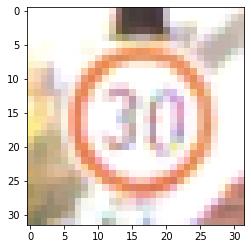

In [50]:
plt.imshow(X_test[400])

In [0]:
df = pd.read_csv("signnames.csv")
labels_dict = df.to_dict()['b']

In [52]:
labels_dict[np.argmax(y_pred_prob[400])]

'Speed limit (20km/h)'

In [0]:
def predict(trained_model, X_test, y_test, scoring=accuracy_score):

  y_test_norm = np.argmax(y_test, axis=1)

  y_pred_prob = trained_model.predict(X_test)
  y_pred = np.argmax(y_pred_prob, axis=1)

  return scoring(y_test_norm, y_pred)

In [61]:
predict(model_trained, X_test, y_test)

0.835827664399093

In [0]:
def train_and_predict(model1):
  model_trained = train_model(model1, X_train, y_train)
  return predict(model_trained, X_test, y_test)

In [65]:
def get_cnn_v2(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape = input_shape),
    MaxPool2D(),
    Dropout(0.3),
    
    Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])
  
train_and_predict(get_cnn_v2(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 3s 11ms/step - loss: 5.0877 - accuracy: 0.2664 - val_loss: 1.7059 - val_accuracy: 0.5388
Epoch 2/5
272/272 [==============================] - 3s 10ms/step - loss: 1.4824 - accuracy: 0.5597 - val_loss: 0.6672 - val_accuracy: 0.8200
Epoch 3/5
272/272 [==============================] - 3s 10ms/step - loss: 0.7996 - accuracy: 0.7554 - val_loss: 0.2625 - val_accuracy: 0.9382
Epoch 4/5
272/272 [==============================] - 3s 10ms/step - loss: 0.4757 - accuracy: 0.8553 - val_loss: 0.1437 - val_accuracy: 0.9683
Epoch 5/5
272/272 [==============================] - 3s 10ms/step - loss: 0.3378 - accuracy: 0.8997 - val_loss: 0.0857 - val_accuracy: 0.9809


0.8832199546485261

In [72]:
def get_cnn_v3(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape = input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation="relu"),
    MaxPool2D(),
    Dropout(0.3),
    
    Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
    Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])
  
train_and_predict(get_cnn_v3(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 4s 16ms/step - loss: 1.8449 - accuracy: 0.5710 - val_loss: 0.2331 - val_accuracy: 0.9432
Epoch 2/5
272/272 [==============================] - 4s 15ms/step - loss: 0.4190 - accuracy: 0.8817 - val_loss: 0.0793 - val_accuracy: 0.9816
Epoch 3/5
272/272 [==============================] - 4s 15ms/step - loss: 0.2471 - accuracy: 0.9294 - val_loss: 0.0431 - val_accuracy: 0.9914
Epoch 4/5
272/272 [==============================] - 4s 15ms/step - loss: 0.1759 - accuracy: 0.9493 - val_loss: 0.0289 - val_accuracy: 0.9929
Epoch 5/5
272/272 [==============================] - 4s 15ms/step - loss: 0.1256 - accuracy: 0.9645 - val_loss: 0.0265 - val_accuracy: 0.9923


0.9605442176870749

In [70]:
def get_cnn_v4(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape = input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same"),
    MaxPool2D(),
    Dropout(0.3),
    
    Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"),
    Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"),
    Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])
  
train_and_predict(get_cnn_v4(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 5s 18ms/step - loss: 2.6536 - accuracy: 0.2895 - val_loss: 1.2409 - val_accuracy: 0.6086
Epoch 2/5
272/272 [==============================] - 5s 17ms/step - loss: 1.0019 - accuracy: 0.6843 - val_loss: 0.2566 - val_accuracy: 0.9222
Epoch 3/5
272/272 [==============================] - 5s 17ms/step - loss: 0.4030 - accuracy: 0.8760 - val_loss: 0.0852 - val_accuracy: 0.9751
Epoch 4/5
272/272 [==============================] - 4s 16ms/step - loss: 0.2587 - accuracy: 0.9219 - val_loss: 0.0510 - val_accuracy: 0.9849
Epoch 5/5
272/272 [==============================] - 5s 17ms/step - loss: 0.1828 - accuracy: 0.9448 - val_loss: 0.0372 - val_accuracy: 0.9902


0.9689342403628118

In [83]:
def get_cnn_v5(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape = input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same"),
    MaxPool2D(),
    Dropout(0.3),
    
    Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"),
    Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"),
    Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation="relu"),
    Dropout(0.3),

    Dense(1024, activation="relu"),
    Dropout(0.3),
    
    Dense(num_classes, activation="softmax")
])
  
train_and_predict(get_cnn_v5(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 5s 18ms/step - loss: 2.4573 - accuracy: 0.3270 - val_loss: 0.8234 - val_accuracy: 0.7316
Epoch 2/5
272/272 [==============================] - 5s 17ms/step - loss: 0.7179 - accuracy: 0.7723 - val_loss: 0.1884 - val_accuracy: 0.9478
Epoch 3/5
272/272 [==============================] - 5s 17ms/step - loss: 0.3773 - accuracy: 0.8826 - val_loss: 0.1079 - val_accuracy: 0.9710
Epoch 4/5
272/272 [==============================] - 5s 18ms/step - loss: 0.2516 - accuracy: 0.9244 - val_loss: 0.0645 - val_accuracy: 0.9838
Epoch 5/5
272/272 [==============================] - 5s 17ms/step - loss: 0.1952 - accuracy: 0.9416 - val_loss: 0.0524 - val_accuracy: 0.9872


0.9700680272108844

In [76]:
# picts are in grb lets limit these dimentions
X_train[0].shape

(32, 32, 3)

In [78]:
color.rgb2gray( X_train[0] ).shape

(32, 32)

In [0]:
X_train_grey = color.rgb2gray( X_train ).reshape(-1, 32, 32, 1)
X_test_grey = color.rgb2gray( X_test ).reshape(-1, 32, 32, 1)

In [110]:
model = get_cnn_v5((32, 32, 1), num_classes)
model_trained = train_model(model, X_train_grey, y_train)
predict(model_trained, X_test_grey, y_test)


Epoch 1/5
272/272 [==============================] - 5s 18ms/step - loss: 2.9502 - accuracy: 0.1791 - val_loss: 1.1406 - val_accuracy: 0.6297
Epoch 2/5
272/272 [==============================] - 5s 17ms/step - loss: 0.6592 - accuracy: 0.7864 - val_loss: 0.1546 - val_accuracy: 0.9513
Epoch 3/5
272/272 [==============================] - 5s 17ms/step - loss: 0.2516 - accuracy: 0.9194 - val_loss: 0.0627 - val_accuracy: 0.9809
Epoch 4/5
272/272 [==============================] - 5s 17ms/step - loss: 0.1691 - accuracy: 0.9469 - val_loss: 0.0350 - val_accuracy: 0.9893
Epoch 5/5
272/272 [==============================] - 5s 17ms/step - loss: 0.1167 - accuracy: 0.9634 - val_loss: 0.0202 - val_accuracy: 0.9941


0.9714285714285714

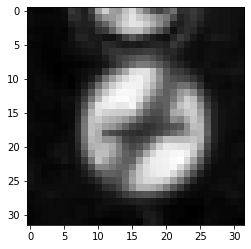

In [100]:
plt.imshow( color.rgb2gray( X_train[0]), cmap=plt.get_cmap("gray"))

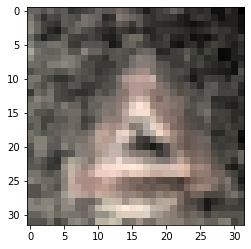

In [106]:
def preproc_img(img):
  hsv = color.rgb2hsv(img)
  hsv[:,:,2] = exposure.equalize_adapthist(hsv[:,:,2])
  img = color.hsv2rgb(hsv)
  return img

plt.imshow( preproc_img(X_train[400]))